In [15]:
import numpy as np
import torch
import os
import matplotlib.pyplot as plt
from torchvision.ops import FeaturePyramidNetwork
from utils.clip import load_clip
import einops
import torch.nn as nn
import torch.nn.functional as F
from utils.layers import RelativeCrossAttentionModule
from models.conditional_unet1d import ConditionalUnet1D
from utils.position_encodings import SinusoidalPosEmb
from diffusers.schedulers.scheduling_ddpm import DDPMScheduler
from utils.position_encodings import RotaryPositionEncoding, RotaryPositionEncoding3D, RotaryPositionEncoding2D
from tqdm.auto import tqdm
import copy
import matplotlib.pyplot as plt


In [16]:
class PushTDataset(torch.utils.data.Dataset):
    def __init__(self, rgb, goal_mask, tee_mask, agent_mask, agent_pos, goal_pose):
        self.rgb = rgb
        self.target = goal_mask
        self.tee_mask = tee_mask
        self.agent_mask = agent_mask
        self.agent_pos = agent_pos
        self.goal_pose = goal_pose

    def __getitem__(self, index):
        item = {}
        item['rgb'] = self.rgb[index]
        item['goal_mask'] = self.target[index]
        item['tee_mask'] = self.tee_mask[index]
        item['agent_mask'] = self.agent_mask[index]
        item['agent_pos'] = self.agent_pos[index]
        item['goal_pose'] = self.goal_pose[index]
        return item

    def __len__(self):
        return len(self.rgb)


def get_loader(data_dir='../data/', num_files=-1):
    files = os.listdir(data_dir)
    files = [f for f in files if f.endswith('.npz')]
    files = files[:num_files] if num_files > 0 else files
    rgb = []
    goal_mask = []
    tee_mask = []
    agent_mask = []
    agent_pos = []
    goal_pose = []

    for f in files:
        el = np.load(data_dir + f)
        rgb.append(el['image'])
        goal_mask.append(el['goal_mask'])
        tee_mask.append(el['tee_mask'])
        agent_mask.append(el['agent_mask'])
        agent_pos.append(el['agent_pos'])
        goal_pose.append(el['goal_pose'])

    rgb = np.stack(rgb, axis=0)
    goal_mask = np.stack(goal_mask, axis=0)
    tee_mask = np.stack(tee_mask, axis=0)
    agent_mask = np.stack(agent_mask, axis=0)
    agent_pos = np.stack(agent_pos, axis=0)
    goal_pose = np.stack(goal_pose, axis=0)

    rgb = torch.from_numpy(rgb).float()
    goal_mask = torch.from_numpy(goal_mask).float()
    tee_mask = torch.from_numpy(tee_mask).float()
    agent_mask = torch.from_numpy(agent_mask).float()
    agent_pos = torch.from_numpy(agent_pos).float()
    goal_pose = torch.from_numpy(goal_pose).float()
    
    dataset = PushTDataset(rgb, goal_mask, tee_mask, agent_mask, agent_pos, goal_pose)

    return torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)

In [17]:
train_loader = get_loader()

item = next(iter(train_loader))

print("item['rgb'].shape", item['rgb'].shape)
print("item['goal_mask'].shape", item['goal_mask'].shape)
print("item['tee_mask'].shape", item['tee_mask'].shape)
print("item['agent_mask'].shape", item['agent_mask'].shape)
print("item['agent_pos'].shape", item['agent_pos'].shape)
print("item['goal_pose'].shape", item['goal_pose'].shape)


item['rgb'].shape torch.Size([9, 3, 96, 96])
item['goal_mask'].shape torch.Size([9, 96, 96])
item['tee_mask'].shape torch.Size([9, 96, 96])
item['agent_mask'].shape torch.Size([9, 96, 96])
item['agent_pos'].shape torch.Size([9, 2])
item['goal_pose'].shape torch.Size([9, 3])


In [51]:
from models.ema_model import EMAModel
from diffusers.optimization import get_scheduler
from policy.goal_diffusion_transformer_image import DiffusionTransformerImage

num_epochs = 10000
embedding_dim = 60
action_dim = 2
device = torch.device('cuda')
num_diffusion_iters = 100
noise_scheduler = DDPMScheduler(
    num_train_timesteps=num_diffusion_iters,
    # the choise of beta schedule has big impact on performance
    # we found squared cosine works the best
    beta_schedule='squaredcos_cap_v2',
    # clip output to [-1,1] to improve stability
    clip_sample=True,
    # our network predicts noise (instead of denoised action)
    prediction_type='epsilon'
)
model = DiffusionTransformerImage(action_dim=2,
                                noise_scheduler=noise_scheduler,
                                vis_backbone='clip',
                                re_cross_attn_layer=4,
                                re_cross_attn_num_heads=3,
                                embedding_dim=embedding_dim,
                                device='cuda')

num_noised_samples = 10

ema_model = copy.deepcopy(model)
_ = model.to(device)
_ = ema_model.to(device)
ema = EMAModel(ema_model)


optimizer = torch.optim.AdamW(
    params=model.parameters(),
    lr=1e-4, weight_decay=1e-6)

lr_scheduler = get_scheduler(
    name='cosine',
    optimizer=optimizer,
    num_warmup_steps=500,
    num_training_steps=len(train_loader) * num_epochs
)

def replicate_batch(item, num_copies):
    for key in item:
        item[key] = einops.repeat(item[key], 'b ... -> (b copy) ...', copy=num_copies)
    return item

with tqdm(range(num_epochs), desc='Epoch') as tglobal:
    losses = list()
    for epoch_idx in tglobal:
        epoch_loss = list()
        # batch loop
        with tqdm(train_loader, desc='Batch', leave=False) as tepoch:
            for item in tepoch:
                item = {k: v.to(device) for k, v in item.items()}
                item = replicate_batch(item, num_copies=num_noised_samples)
                loss = model.compute_loss(item)
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()
                # step lr scheduler every batch
                # this is different from standard pytorch behavior
                lr_scheduler.step()

                # update Exponential Moving Average of the model weights
                ema.step(model)

                # logging
                loss_cpu = loss.item()
                epoch_loss.append(loss_cpu)
                tepoch.set_postfix(loss=loss_cpu)
        epoch_loss = np.mean(epoch_loss)
        losses.append(epoch_loss)
        tglobal.set_postfix(loss=epoch_loss)

ema_model = ema.averaged_model

Epoch:  21%|██        | 2106/10000 [01:11<04:28, 29.41it/s, loss=0.00175] 

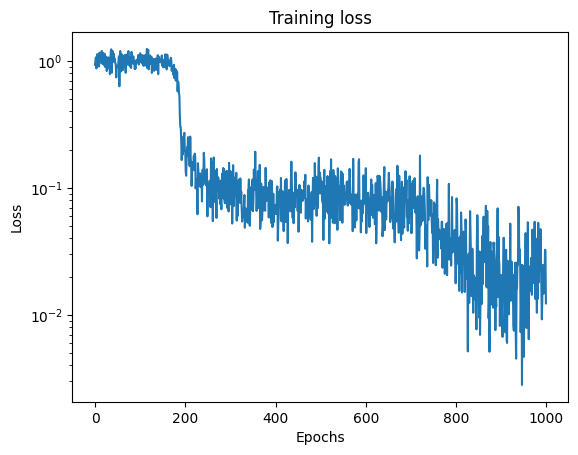

In [33]:
plt.plot(losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training loss')
plt.yscale('log')
plt.show()

tensor([[256.0000, 256.0000,   0.7854]])


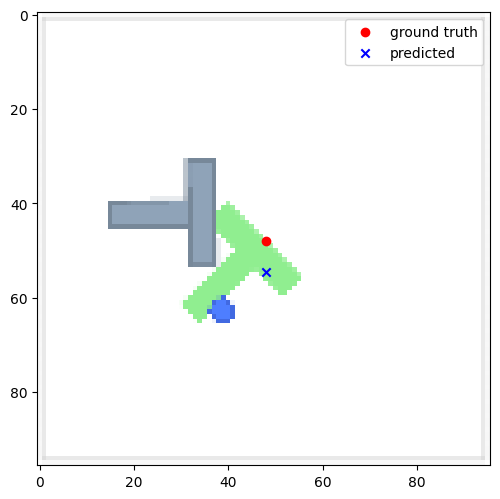

In [50]:
item = next(iter(train_loader))
item = {k: v[:1] for k, v in item.items()}
print(item["goal_pose"])
loss = model.compute_loss(item)
out = model.predict_action(item).cpu().detach().numpy()
fig = plt.figure(figsize=(20, 20))
for i, goal_pos_pred in enumerate(out[:9]):
    agent_pos = item['agent_pos'][i]
    goal_pos_pred_image = (agent_pos + goal_pos_pred) / 512.0 * 96.
    goal_pos_image = item['goal_pose'][i] / 512.0 * 96.
    ax = fig.add_subplot(3, 3, i + 1)
    ax.imshow(item['rgb'][i].permute(1, 2, 0).cpu().numpy())
    ax.scatter(goal_pos_image[0], goal_pos_image[1], c='r', label='ground truth')
    ax.scatter(goal_pos_pred_image[0], goal_pos_pred_image[1], c='b', marker='x', label='predicted')
    ax.legend()
plt.show() 